In [1]:
from typing import *
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

# Model

In [22]:
# https://github.com/milesial/Pytorch-UNet

class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b

class ConvNextBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_dim, expansion=3):
        super().__init__()
        self.t_proj = nn.Linear(t_dim, in_channels)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=7, padding=3),
            LayerNorm(in_channels),
            nn.Conv2d(in_channels, expansion*in_channels, kernel_size=1, padding=0),
            nn.GELU(),
            nn.Conv2d(expansion*in_channels, out_channels, kernel_size=1, padding=0),
        )
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x, t_emb):
        h = x + self.t_proj(t_emb)[:, :, None, None].expand_as(x)
        h = self.conv(h)
        return h + self.res_conv(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, t_dim, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = ConvNextBlock(in_channels, mid_channels, t_dim)
        self.conv2 = ConvNextBlock(mid_channels, out_channels, t_dim)
    
    def forward(self, x, t_emb):
        h = self.conv1(x, t_emb)
        #h = self.conv2(h, t_emb)
        return h

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, t_dim):
        super().__init__()
        
        self.conv = DoubleConv(in_channels, out_channels, t_dim)
        self.pool = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t_emb):
        return self.pool(self.conv(x, t_emb))


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, t_dim):
        super().__init__()

        self.unpool = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, t_dim)

    def forward(self, x1, x2, t_emb):
        x1 = self.unpool(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x, t_emb)
    
    
class UNet(nn.Module):
    def __init__(self, n_channels=3, t_dim=256):
        super().__init__()
        self.n_channels = n_channels

        self.inc = DoubleConv(n_channels, 64, t_dim)
        self.down1 = Down(64, 128, t_dim)
        self.down2 = Down(128, 256, t_dim)
        self.down3 = Down(256, 512, t_dim)
        self.down4 = Down(512, 1024, t_dim)
        self.up1 = Up(1024, 512, t_dim)
        self.up2 = Up(512, 256, t_dim)
        self.up3 = Up(256, 128, t_dim)
        self.up4 = Up(128, 64, t_dim)
        self.outc = nn.Conv2d(64, n_channels, kernel_size=1)

    def forward(self, x, t):
        x1 = self.inc(x, t)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)
        #x5 = self.down4(x4, t)
        #x = self.up1(x5, x4, t)
        x = x4
        x = self.up2(x, x3, t)
        x = self.up3(x, x2, t)
        x = self.up4(x, x1, t)
        logits = self.outc(x)
        return logits

In [23]:
class TimeEmbedding(nn.Module):
    def __init__(self, max_t: int, out_dim: int = 256, hidden_dim: int = 64):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(max_t, hidden_dim),
            nn.Linear(hidden_dim, out_dim), nn.ReLU(),
            nn.Linear(out_dim, out_dim), nn.ReLU(),
        )
    
    def forward(self, t):
        return self.embed(t)

class DiffusionModule(nn.Module):
    def __init__(self,
        max_t: int = 1000,
        beta_1: float = 1e-4,
        beta_t: float = 1e-2,
        t_dim: int = 256
    ):
        super().__init__()
        self.max_t = max_t
        betas = np.linspace(beta_1, beta_t, self.max_t)
        self.alphas = torch.tensor(np.cumprod(1 - betas), dtype=torch.float)
        
        self.t_embed = TimeEmbedding(max_t, t_dim)
        self.unet = UNet(t_dim=t_dim)
        
    def add_noise(self, x, t):
        batch_size = x.size(0)
        alphas = torch.gather(self.alphas.unsqueeze(0).expand(batch_size, -1), 1, t.unsqueeze(1))
        alphas = alphas[:, :, None, None].expand_as(x)
        
        eps = torch.randn_like(x)
        x_hat = torch.sqrt(alphas)*x + torch.sqrt(1 - alphas)*eps
        
        return x_hat, eps
        
    def get_loss(self, x):
        batch_size = x.size(0)
        t = torch.randint(self.max_t, size=(batch_size,))
        x_hat, eps = self.add_noise(x, t)
        
        eps_hat = self.forward(x_hat, t)
        
        loss = F.mse_loss(eps, eps_hat)
        
        return loss
        
    def forward(self, x, t):
        t_emb = self.t_embed(t)
        return self.unet(x, t_emb)

In [24]:
model = DiffusionModule()

# Data

In [5]:
ds = torchvision.datasets.CIFAR100("../data/cifar", download=True, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

Files already downloaded and verified


In [6]:
class DiffusionCollator:
    def __init__(self, max_t: int = 1000, beta_1: float = 1e-4, beta_t: float = 1e-2):
        self.max_t = max_t
        self.betas = np.linspace(beta_1, beta_t, self.max_t)
        self.alphas = np.cumprod(1 - self.betas)
    
    def __call__(self, examples):
        x, _ = list(zip(*examples))
        x = torch.stack(x)
        return x

data_collator = DiffusionCollator()
dl = DataLoader(ds, batch_size=8, collate_fn=data_collator)

In [7]:
def show_image(x, axis=plt):
    axis.imshow(torch.clip(x.transpose(0, 1).transpose(1, 2)*0.5 + 0.5, 0, 1))

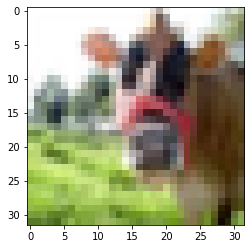

In [8]:
img, label = ds[0]
show_image(img)
plt.show()

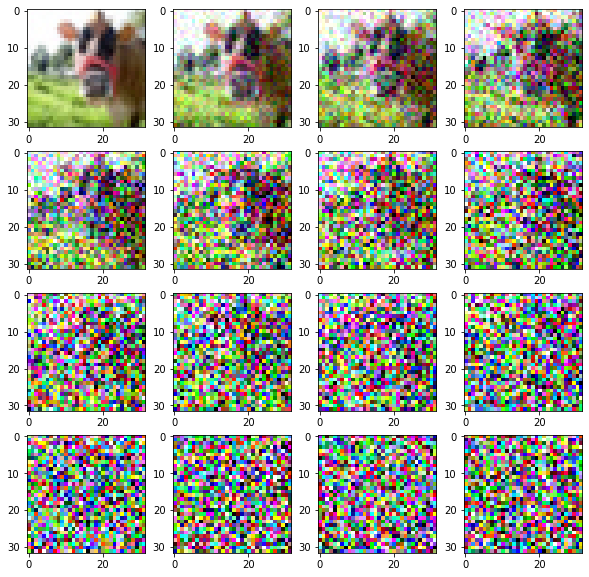

In [9]:
x = next(iter(dl))

plt.figure(figsize=(10, 10))

for i, t in enumerate(range(0, 999, 65)):
    ts = torch.zeros(size=(x.size(0),), dtype=int).fill_(t)
    x_hat, eps = model.add_noise(x, ts)

    plt.subplot(4, 4, i + 1)
    show_image(x_hat[0])
    
plt.show()

# Training

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
with tqdm(dl) as pbar:
    for batch in pbar:
        loss = model.get_loss(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

In [98]:
w, h = 128, 128
F.mse_loss(torch.randn(8, 3, w, h), torch.randn(8, 3, w, h))

tensor(1.9991)

In [127]:
w = 1024
x1, x2 = torch.randn(8, 3, w, w), torch.randn(8, 3, w, w)

((x1 - x2)**2).sum(dim=1).mean()

tensor(6.0022)